In [3]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [4]:
#Load Dataset
dataset=pd.read_csv('C:/Users/Owner/Desktop/Raisin_Dataset.csv')
dataset.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Owner/Desktop/Raisin_Dataset.csv'

In [4]:
#Show Key Statistics
dataset.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000


In [1]:
#Importing package
import pandas_profiling as pp
from IPython.display import IFrame
 
# Profile Report
RaisinReport = pp.ProfileReport(dataset)
RaisinReport.to_file('RaisinReportW5a-lbfgs.html')
display(IFrame('RaisinReportW5a-lbfgs.html', width=900, height=350))

# Save the report as an HTML file
RaisinReport.to_file('C:/Users/Owner/Desktop/Durham/Semester 2/Statistics/Assignment-3_profile_report.html')

NameError: name 'dataset' is not defined

In [8]:
#Create x and y variables
x = dataset.drop('Class', axis=1).to_numpy()
Y = dataset['Class'].to_numpy()

#Create Train and Test Dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_smt)
x_test2 = sc.transform(x_test)

#Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [9]:
#Class Balance - Test Data
print('Train Data - Class Split')
num_zeros = (y_train_smt == 'Kecimen').sum()
num_ones = (y_train_smt == 'Besni').sum()
print('Kecimen -',  num_zeros)
print('Besni -',  num_ones)

Train Data - Class Split
Kecimen - 360
Besni - 360


In [11]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline
pipeline =[]

pipe_lda = Pipeline([('scl', StandardScaler()),
                    ('clf', LinearDiscriminantAnalysis())])
pipeline.insert(0,pipe_lda)

pipe_qda = Pipeline([('scl', StandardScaler()),
                    ('clf', QuadraticDiscriminantAnalysis())])
pipeline.insert(1,pipe_qda)

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='liblinear',
                                               class_weight='balanced',
                                               random_state=100))])   
pipeline.insert(2,pipe_logreg)
    
    
# Set grid search params 

modelpara =[]

param_gridlda = {'clf__solver':['svd','lsqr','eigen']}
modelpara.insert(0,param_gridlda)

param_gridqda = {}
modelpara.insert(1,param_gridqda)

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l1', 'l2']}
modelpara.insert(2,param_gridlogreg)

In [12]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train_smt, y_train_smt)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Validation Statistics
    target_names=['Kecimen','Besni']
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
        
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


Optimized Model

Model Name: LinearDiscriminantAnalysis()

Best Parameters: {'clf__solver': 'svd'}

 [[76 14]
 [12 78]]

               precision    recall  f1-score   support

     Kecimen       0.86      0.84      0.85        90
       Besni       0.85      0.87      0.86        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180

ROC Curve


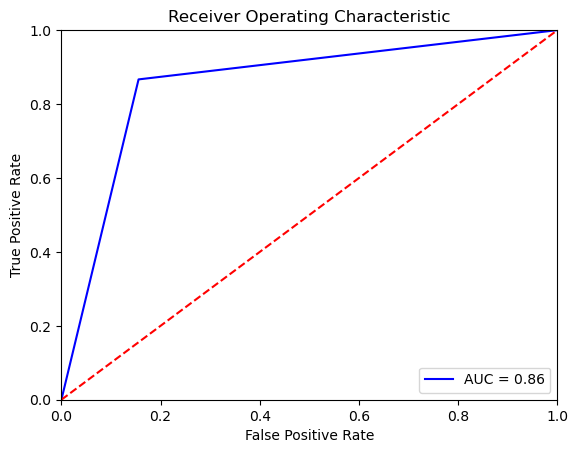


Optimized Model

Model Name: QuadraticDiscriminantAnalysis()

Best Parameters: {}

 [[73 17]
 [ 3 87]]

               precision    recall  f1-score   support

     Kecimen       0.96      0.81      0.88        90
       Besni       0.84      0.97      0.90        90

    accuracy                           0.89       180
   macro avg       0.90      0.89      0.89       180
weighted avg       0.90      0.89      0.89       180

ROC Curve


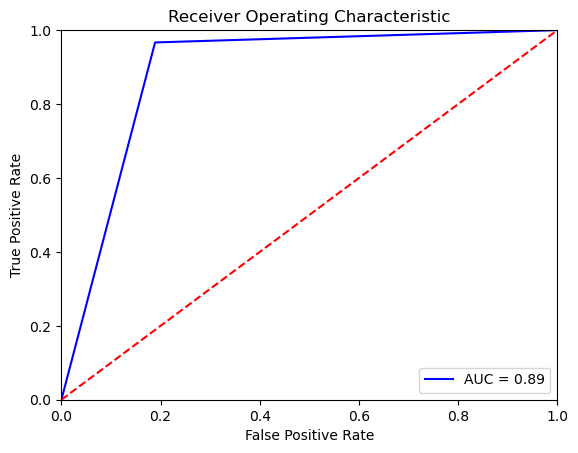


Optimized Model

Model Name: LogisticRegression(class_weight='balanced', random_state=100,
                   solver='liblinear')

Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2'}

 [[75 15]
 [12 78]]

               precision    recall  f1-score   support

     Kecimen       0.86      0.83      0.85        90
       Besni       0.84      0.87      0.85        90

    accuracy                           0.85       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.85      0.85      0.85       180

ROC Curve


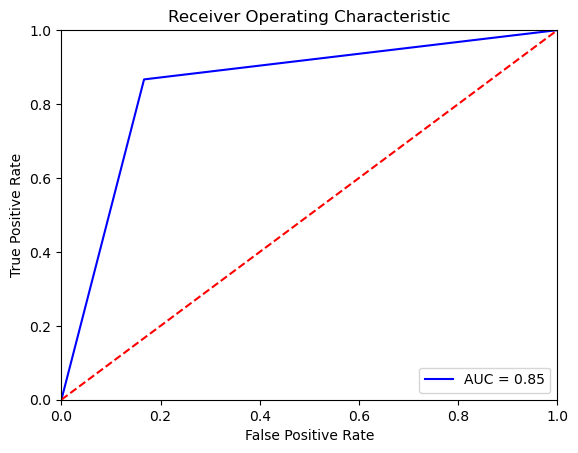

In [13]:
#Run Models
for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)